# Импорт необходимых библиотек:

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import random
import urllib.request
import tarfile
import shutil
from PIL import Image

import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, top_k_accuracy_score

In [2]:
url = "http://www.soshnikov.com/permanent/data/petfaces.tar.gz"
file_name = "petfaces.tar.gz"

urllib.request.urlretrieve(url, file_name)
print("Файл успешно скачан.")

with tarfile.open(file_name, "r:gz") as tar:
    tar.extractall()
print("Архив успешно разархивирован.")

os.remove(file_name)
print("Архив успешно удален.")

folder_path = 'petfaces'
folders = [f.path for f in os.scandir(folder_path) if f.is_dir()]

Файл успешно скачан.
Архив успешно разархивирован.
Архив успешно удален.


# Предобработка и визуализация данных:

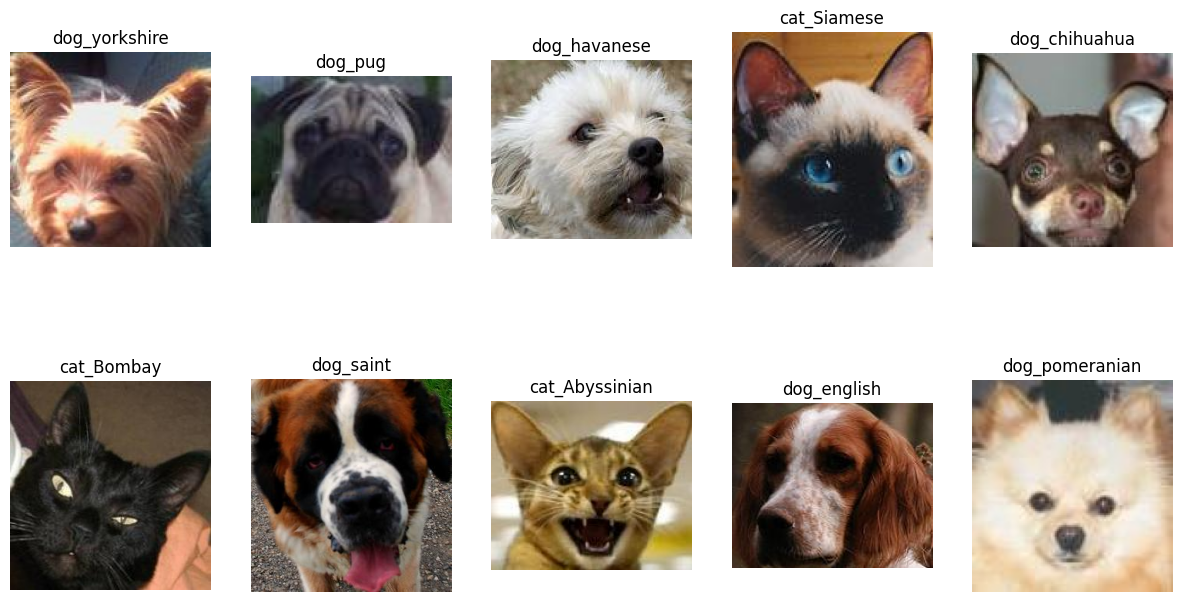

In [3]:
def visualize_pet_images(folder_path, num_images=5):
    pet_breeds = os.listdir(folder_path)

    plt.figure(figsize=(15, 8))

    num_rows = num_images // 5
    remainder = num_images % 5

    for row in range(num_rows):
        selected_breeds = random.sample(pet_breeds, 5)
        for i, breed in enumerate(selected_breeds, start=1):
            breed_path = os.path.join(folder_path, breed)
            pet_images = os.listdir(breed_path)
            random_image = random.choice(pet_images)
            image_path = os.path.join(breed_path, random_image)
            img = mpimg.imread(image_path)
            plt.subplot(num_rows, 5, row*5 + i)
            plt.imshow(img)
            plt.title(breed)
            plt.axis('off')

    if remainder > 0:
        selected_breeds = random.sample(pet_breeds, remainder)
        for i, breed in enumerate(selected_breeds, start=1):
            breed_path = os.path.join(folder_path, breed)
            pet_images = os.listdir(breed_path)
            random_image = random.choice(pet_images)
            image_path = os.path.join(breed_path, random_image)
            img = mpimg.imread(image_path)
            plt.subplot(1, remainder, i)
            plt.imshow(img)
            plt.title(breed)
            plt.axis('off')

    plt.show()

visualize_pet_images(folder_path, num_images=10)

In [ ]:
def count_images(folder_path):
    total_count = 0
    cat_count = 0
    dog_count = 0
    breed_counts = {}

    pet_breeds = os.listdir(folder_path)

    for breed in pet_breeds:
        breed_path = os.path.join(folder_path, breed)
        if os.path.isdir(breed_path):
            images = os.listdir(breed_path)
            count = len(images)
            breed_counts[breed] = count
            total_count += count
            if "cat" in breed.lower():
                cat_count += count
            elif "dog" in breed.lower():
                dog_count += count

    return total_count, cat_count, dog_count, breed_counts

total_count, cat_count, dog_count, breed_counts = count_images(folder_path)

In [ ]:
print("Общее количество фотографий:", total_count)
print("Количество фотографий кошек:", cat_count)
print("Количество фотографий собак:", dog_count)
print("Количество фотографий для каждой породы:")
for breed, count in breed_counts.items():
    print(f"{breed}: {count}")

Общее количество фотографий: 3211
Количество фотографий кошек: 1106
Количество фотографий собак: 2105
Количество фотографий для каждой породы:
cat_Abyssinian: 92
cat_Bengal: 74
cat_Birman: 98
cat_Bombay: 87
cat_British: 100
cat_Egyptian: 73
cat_Maine: 95
cat_Persian: 94
cat_Ragdoll: 96
cat_Russian: 97
cat_Siamese: 100
cat_Sphynx: 100
dog_american: 174
dog_basset: 88
dog_beagle: 78
dog_boxer: 85
dog_chihuahua: 83
dog_english: 182
dog_german: 69
dog_great: 91
dog_havanese: 93
dog_japanese: 74
dog_keeshond: 83
dog_leonberger: 95
dog_miniature: 75
dog_newfoundland: 98
dog_pomeranian: 90
dog_pug: 89
dog_saint: 90
dog_samoyed: 68
dog_scottish: 59
dog_shiba: 82
dog_staffordshire: 87
dog_wheaten: 91
dog_yorkshire: 81


In [ ]:
dogs_cats_path = "dogs_cats"
train_path = os.path.join(dogs_cats_path, "train")
test_path = os.path.join(dogs_cats_path, "test")

os.makedirs(train_path, exist_ok=True)
os.makedirs(test_path, exist_ok=True)

train_cats_path = os.path.join(train_path, "cats")
train_dogs_path = os.path.join(train_path, "dogs")
test_cats_path = os.path.join(test_path, "cats")
test_dogs_path = os.path.join(test_path, "dogs")

os.makedirs(train_cats_path, exist_ok=True)
os.makedirs(train_dogs_path, exist_ok=True)
os.makedirs(test_cats_path, exist_ok=True)
os.makedirs(test_dogs_path, exist_ok=True)

In [ ]:
for subfolder in folders:
    breed_name = os.path.basename(subfolder)
    if 'cat' in breed_name:
        cat_files = [os.path.join(subfolder, file) for file in os.listdir(subfolder)]
        split_index = int(0.8 * len(cat_files))
        train_cat_files = cat_files[:split_index]
        test_cat_files = cat_files[split_index:]
        for file in train_cat_files:
            shutil.copy(file, train_cats_path)
        for file in test_cat_files:
            shutil.copy(file, test_cats_path)
    elif 'dog' in breed_name:
        dog_files = [os.path.join(subfolder, file) for file in os.listdir(subfolder)]
        split_index = int(0.8 * len(dog_files))
        train_dog_files = dog_files[:split_index]
        test_dog_files = dog_files[split_index:]
        for file in train_dog_files:
            shutil.copy(file, train_dogs_path)
        for file in test_dog_files:
            shutil.copy(file, test_dogs_path)

print("Количество фотографий кошек в обучающем наборе:", len(os.listdir(train_cats_path)))
print("Количество фотографий кошек в тестовом наборе:", len(os.listdir(test_cats_path)))
print("Количество фотографий собак в обучающем наборе:", len(os.listdir(train_dogs_path)))
print("Количество фотографий собак в тестовом наборе:", len(os.listdir(test_dogs_path)))

Количество фотографий кошек в обучающем наборе: 881
Количество фотографий кошек в тестовом наборе: 225
Количество фотографий собак в обучающем наборе: 1676
Количество фотографий собак в тестовом наборе: 429


# Бинарная классификация:

In [ ]:
image_size = 224
batch_size = 32

train_transforms = transforms.Compose([
    transforms.Resize((image_size, image_size)),  # Изменение размера изображения
    transforms.RandomRotation(20),  # Вращение изображения на случайный угол до 20 градусов
    transforms.RandomResizedCrop(image_size),  # Случайное масштабирование и обрезка изображения
    transforms.RandomHorizontalFlip(),  # Случайное отражение изображения по горизонтали
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),  # Изменение цвета изображения
    transforms.ToTensor(),  # Преобразование изображения в тензор
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Нормализация данных
])

test_transforms = transforms.Compose([
    transforms.Resize((image_size, image_size)),  # Изменение размера изображения
    #transforms.CenterCrop(image_size),  # Обрезка центральной части изображения
    transforms.ToTensor(),  # Преобразование изображения в тензор
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Нормализация данных
])

train_data = datasets.ImageFolder(root="dogs_cats/train", transform=train_transforms)
test_data = datasets.ImageFolder(root="dogs_cats/test", transform=test_transforms)

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

(len(train_loader), len(test_loader))

(80, 21)

In [ ]:
X_batch, y_batch = next(iter(train_loader))
X_batch.shape, y_batch.shape

(torch.Size([32, 3, 224, 224]), torch.Size([32]))

In [ ]:
input_size = 3
num_classes = 2

class ConvNet(nn.Module):
    def __init__(self, num_classes):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(64 * 28 * 28, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 64 * 28 * 28)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = ConvNet(num_classes=num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

train_loss_history = []
test_loss_history = []
train_acc_history = []
test_acc_history = []

In [ ]:
# Обучение модели
num_epochs = 10
for epoch in range(num_epochs):
    # Обучение
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for images, labels in train_loader:
        # Обнуляем градиенты
        optimizer.zero_grad()
        # Передаем данные через модель
        outputs = model(images)
        # Вычисляем потери
        loss = criterion(outputs, labels)
        # Обратное распространение и оптимизация
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct_train / total_train
    train_loss_history.append(train_loss)
    train_acc_history.append(train_accuracy)

    # Тестирование
    model.eval()
    with torch.no_grad():
        running_loss = 0.0
        correct_test = 0
        total_test = 0
        for images, labels in test_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

    test_loss = running_loss / len(test_loader)
    test_accuracy = 100 * correct_test / total_test
    test_loss_history.append(test_loss)
    test_acc_history.append(test_accuracy)

    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, '
          f'Test Loss: {test_loss:.4f}, Test Acc: {test_accuracy:.2f}%')

Epoch [1/10], Train Loss: 0.6462, Train Acc: 65.19%, Test Loss: 0.6332, Test Acc: 65.60%
Epoch [2/10], Train Loss: 0.6408, Train Acc: 65.55%, Test Loss: 0.6258, Test Acc: 65.60%
Epoch [3/10], Train Loss: 0.6311, Train Acc: 65.55%, Test Loss: 0.6184, Test Acc: 65.60%
Epoch [4/10], Train Loss: 0.6244, Train Acc: 65.66%, Test Loss: 0.6076, Test Acc: 66.97%
Epoch [5/10], Train Loss: 0.6227, Train Acc: 65.86%, Test Loss: 0.6030, Test Acc: 65.75%
Epoch [6/10], Train Loss: 0.6265, Train Acc: 65.94%, Test Loss: 0.5890, Test Acc: 68.96%
Epoch [7/10], Train Loss: 0.6146, Train Acc: 66.60%, Test Loss: 0.5930, Test Acc: 73.39%
Epoch [8/10], Train Loss: 0.6185, Train Acc: 67.42%, Test Loss: 0.5776, Test Acc: 70.80%
Epoch [9/10], Train Loss: 0.6016, Train Acc: 67.85%, Test Loss: 0.5656, Test Acc: 74.62%
Epoch [10/10], Train Loss: 0.5987, Train Acc: 68.36%, Test Loss: 0.5597, Test Acc: 74.62%


Оценка для бин. классификации

In [ ]:
def evaluate_model(model, test_loader, criterion):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    test_loss /= len(test_loader)
    accuracy = 100 * correct / total
    return test_loss, accuracy

test_loss, test_accuracy = evaluate_model(model, test_loader, criterion)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

Test Loss: 0.5597, Test Accuracy: 74.62%


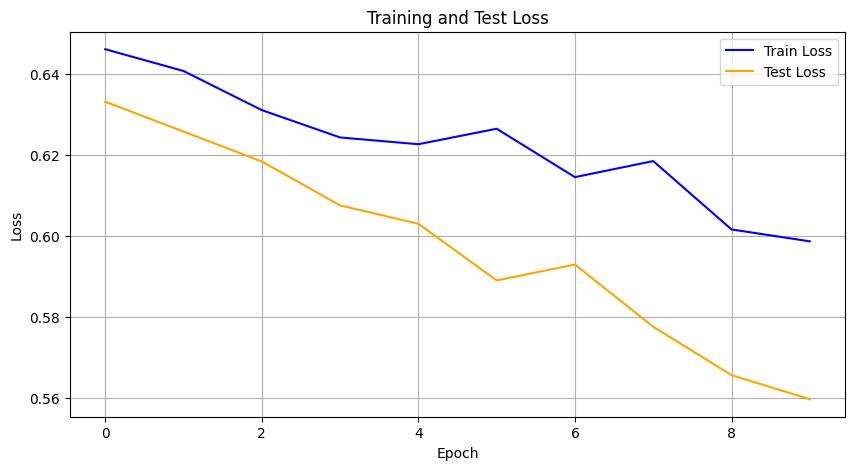

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(train_loss_history, label='Train Loss', color='blue')
plt.plot(test_loss_history, label='Test Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()
plt.grid(True)
plt.show()

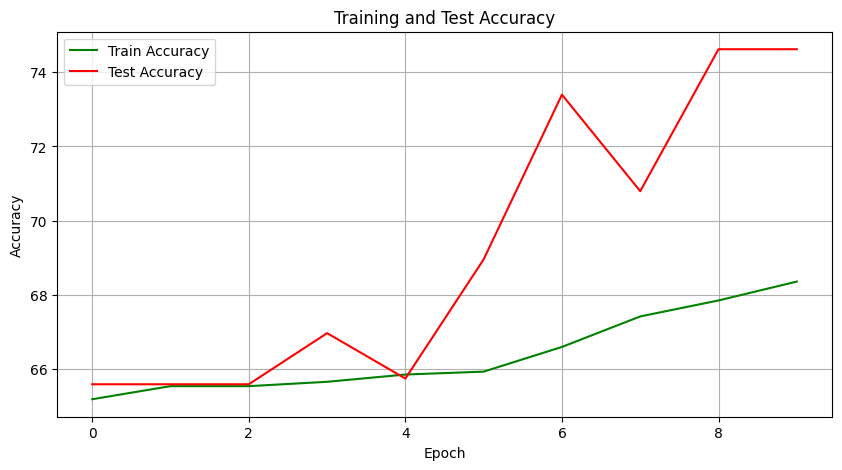

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(train_acc_history, label='Train Accuracy', color='green')
plt.plot(test_acc_history, label='Test Accuracy', color='red')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
from matplotlib.cm import jet

In [ ]:
def get_predicted_and_true_labels(model, dataloader):
    model.eval()
    predicted_labels = []
    true_labels = []
    with torch.no_grad():
        for images, labels in dataloader:
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            predicted_labels.extend(predicted.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
    return predicted_labels, true_labels

predicted_labels, true_labels = get_predicted_and_true_labels(model, test_loader)
conf_matrix = confusion_matrix(true_labels, predicted_labels)

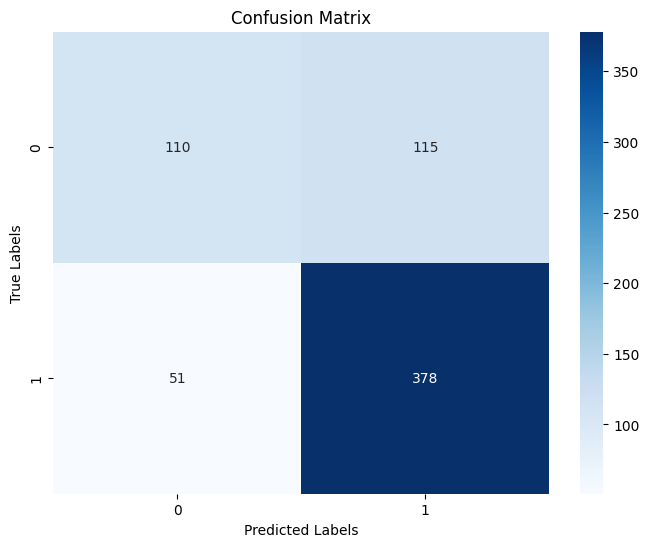

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Мультиклассовая классификация:

In [ ]:
source_folder = "petfaces"
target_folder = "petfaces_split"
os.makedirs(target_folder, exist_ok=True)

train_folder = os.path.join(target_folder, "train")
test_folder = os.path.join(target_folder, "test")
os.makedirs(train_folder, exist_ok=True)
os.makedirs(test_folder, exist_ok=True)

for root, dirs, files in os.walk(source_folder):
    for d in dirs:
        breed_folder = os.path.join(root, d)

        train_breed_folder = os.path.join(train_folder, d)
        test_breed_folder = os.path.join(test_folder, d)
        os.makedirs(train_breed_folder, exist_ok=True)
        os.makedirs(test_breed_folder, exist_ok=True)

        images = [f for f in os.listdir(breed_folder) if os.path.isfile(os.path.join(breed_folder, f))]

        train_images, test_images = train_test_split(images, test_size=0.2, random_state=42)

        for image in train_images:
            shutil.copy(os.path.join(breed_folder, image), os.path.join(train_breed_folder, image))

        for image in test_images:
            shutil.copy(os.path.join(breed_folder, image), os.path.join(test_breed_folder, image))

In [ ]:
train_data = datasets.ImageFolder(root="petfaces_split/train", transform=train_transforms)
test_data = datasets.ImageFolder(root="petfaces_split/test", transform=test_transforms)

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

(len(train_loader), len(test_loader))

(80, 21)

In [ ]:
X_batch, y_batch = next(iter(train_loader))
X_batch.shape, y_batch.shape,

(torch.Size([32, 3, 224, 224]), torch.Size([32]))

In [ ]:
input_size = 3
num_classes = 35

class ConvNet(nn.Module):
    def __init__(self, num_classes):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(64 * 28 * 28, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 64 * 28 * 28)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = ConvNet(num_classes=num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

train_loss_history = []
test_loss_history = []
train_acc_history = []
test_acc_history = []

In [ ]:
# Обучение модели
num_epochs = 10
for epoch in range(num_epochs):
    # Обучение
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for images, labels in train_loader:
        # Обнуляем градиенты
        optimizer.zero_grad()
        # Передаем данные через модель
        outputs = model(images)
        # Вычисляем потери
        loss = criterion(outputs, labels)
        # Обратное распространение и оптимизация
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct_train / total_train
    train_loss_history.append(train_loss)
    train_acc_history.append(train_accuracy)

    # Тестирование
    model.eval()
    with torch.no_grad():
        running_loss = 0.0
        correct_test = 0
        total_test = 0
        for images, labels in test_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

    test_loss = running_loss / len(test_loader)
    test_accuracy = 100 * correct_test / total_test
    test_loss_history.append(test_loss)
    test_acc_history.append(test_accuracy)

    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, '
          f'Test Loss: {test_loss:.4f}, Test Acc: {test_accuracy:.2f}%')

Epoch [1/10], Train Loss: 3.5343, Train Acc: 5.24%, Test Loss: 3.5040, Test Acc: 5.81%
Epoch [2/10], Train Loss: 3.4455, Train Acc: 6.37%, Test Loss: 3.3598, Test Acc: 7.03%
Epoch [3/10], Train Loss: 3.3239, Train Acc: 8.56%, Test Loss: 3.2240, Test Acc: 11.01%
Epoch [4/10], Train Loss: 3.2673, Train Acc: 9.11%, Test Loss: 3.1171, Test Acc: 17.28%
Epoch [5/10], Train Loss: 3.1958, Train Acc: 12.08%, Test Loss: 3.0400, Test Acc: 17.74%
Epoch [6/10], Train Loss: 3.1482, Train Acc: 12.63%, Test Loss: 2.9570, Test Acc: 17.58%
Epoch [7/10], Train Loss: 3.0874, Train Acc: 13.30%, Test Loss: 2.8840, Test Acc: 21.25%
Epoch [8/10], Train Loss: 3.0533, Train Acc: 15.41%, Test Loss: 2.8328, Test Acc: 22.94%
Epoch [9/10], Train Loss: 2.9910, Train Acc: 17.52%, Test Loss: 2.7216, Test Acc: 25.84%
Epoch [10/10], Train Loss: 2.9680, Train Acc: 17.32%, Test Loss: 2.7301, Test Acc: 24.46%


Оценка для многоклассовой классификации

In [ ]:
test_loss, test_accuracy = evaluate_model(model, test_loader, criterion)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

Test Loss: 2.7301, Test Accuracy: 24.46%


In [ ]:
model.eval()
y_true_indices = []
y_pred_probabilities = []

for images, labels in test_loader:
    outputs = model(images)
    probabilities = torch.softmax(outputs, dim=1)
    y_pred_probabilities.append(probabilities.detach().numpy())
    y_true_indices.extend(labels.numpy())

y_pred_probabilities = np.concatenate(y_pred_probabilities, axis=0)
top3_accuracy = top_k_accuracy_score(y_true_indices, y_pred_probabilities, k=3) * 100

print(f'Top-3 Accuracy: {top3_accuracy:.2f}%')

Top-3 Accuracy: 47.25%


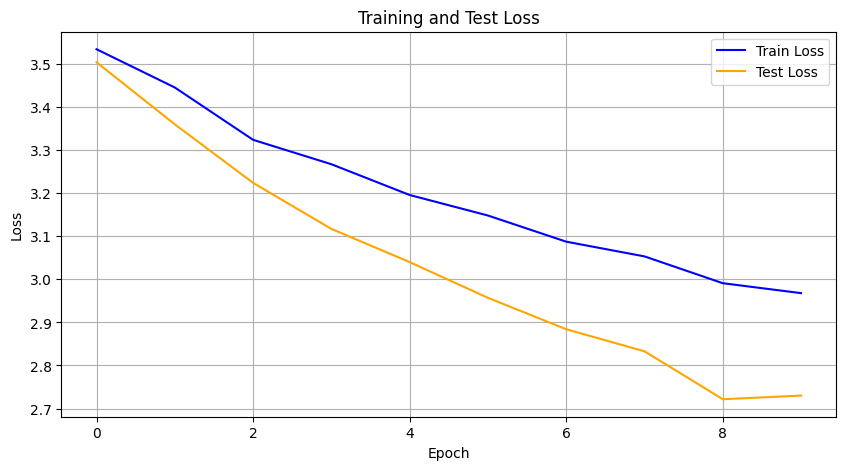

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(train_loss_history, label='Train Loss', color='blue')
plt.plot(test_loss_history, label='Test Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()
plt.grid(True)
plt.show()

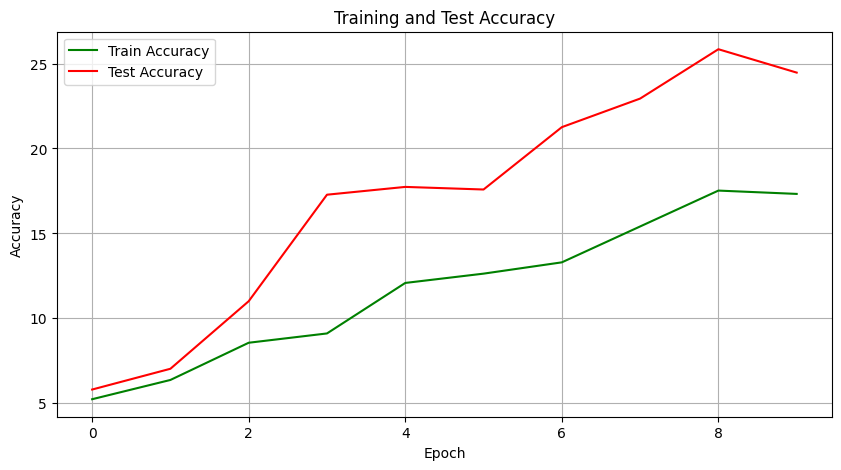

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(train_acc_history, label='Train Accuracy', color='green')
plt.plot(test_acc_history, label='Test Accuracy', color='red')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
predicted_labels, true_labels = get_predicted_and_true_labels(model, test_loader)
conf_matrix = confusion_matrix(true_labels, predicted_labels)

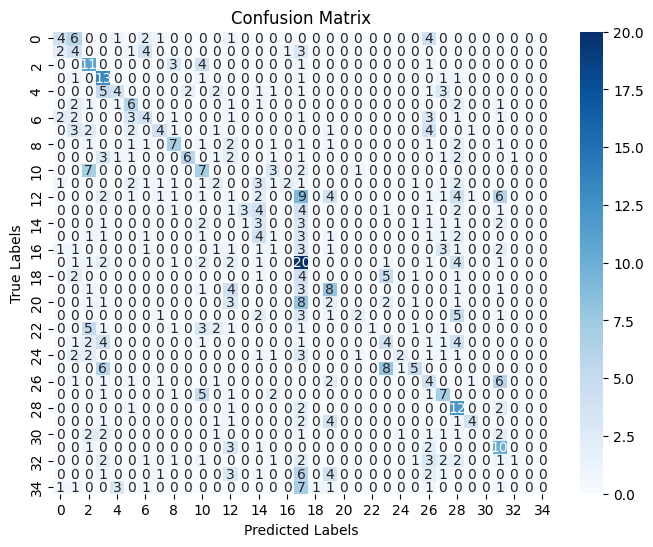

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()